# 第 6 章 网络结构数据的社区发现

## 导入库

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics

from modules.tools import graph_info, map_color, cluster_layout, plot_dendrogram

# 设置图形的显示风格和中文显示
sns.set_theme(font='SimHei')

## 导入数据

In [2]:
# 读取数据
karate = nx.read_graphml('../../Data/karate.graphml')
graph_info(karate)

Zachary's karate club network with 34 nodes and 78 edges.
Graph type:      undirected weighted 
Node attributes: Faction name label color 
Edge attributes: weight 
Edge list:
[ 0] Mr Hi    -- Actor 2 	[ 1] Mr Hi    -- Actor 3 	[ 2] Mr Hi    -- Actor 4 
[ 3] Mr Hi    -- Actor 5 	[ 4] Mr Hi    -- Actor 6 	[ 5] Mr Hi    -- Actor 7 
[ 6] Mr Hi    -- Actor 8 	[ 7] Mr Hi    -- Actor 9 	[ 8] Mr Hi    -- Actor 11
[ 9] Mr Hi    -- Actor 12	[10] Mr Hi    -- Actor 13	[11] Mr Hi    -- Actor 14
[12] Mr Hi    -- Actor 18	[13] Mr Hi    -- Actor 20	[14] Mr Hi    -- Actor 22
[15] Mr Hi    -- Actor 32	[16] Actor 2  -- Actor 3 	[17] Actor 2  -- Actor 4 
...


## Edge Betweenness 算法（Girvan-Newman 算法）

In [3]:
# Girvan-Newman算法， 默认使用networkx.edge_betweenness_centrality作为most_valuable_edge的度量
com_GN = nx.algorithms.community.girvan_newman(karate)
com_GN = list(com_GN) # 转换为list，方便查看结果
# 查看结果：
print(f"共进行了{len(com_GN)}次划分，前5次划分的结果：")
for i in range(5):
    print(f"第{i+1}次 划分出的社区数：{len(com_GN[i])}")

共进行了33次划分，前5次划分的结果：
第1次 划分出的社区数：2
第2次 划分出的社区数：3
第3次 划分出的社区数：4
第4次 划分出的社区数：5
第5次 划分出的社区数：6


In [4]:
# 使用Modularity最大时的划分作为最终结果
com_GN_modularity = {}
for i, com in enumerate(com_GN):
    # 计算模块度
    com_GN_modularity[i] = nx.algorithms.community.quality.modularity(karate, com)
# 按照模块度降序排列
com_GN_modularity = sorted(com_GN_modularity.items(), key=lambda x: x[1], reverse=True)
# 最终结果
com_GN_best = com_GN[com_GN_modularity[0][0]]
print("最终结果：")
print(f"最终划分的社区数：{len(com_GN_best)}")
for i, com in enumerate(com_GN_best):
    print(f"社区{i+1}: {com}")

最终结果：
最终划分的社区数：5
社区1: {'n11', 'n13', 'n19', 'n17', 'n21', 'n0', 'n3', 'n7', 'n1', 'n12'}
社区2: {'n28', 'n27', 'n31', 'n25', 'n24', 'n2'}
社区3: {'n16', 'n5', 'n6', 'n4', 'n10'}
社区4: {'n33', 'n30', 'n29', 'n22', 'n15', 'n32', 'n18', 'n20', 'n26', 'n23', 'n8', 'n14'}
社区5: {'n9'}


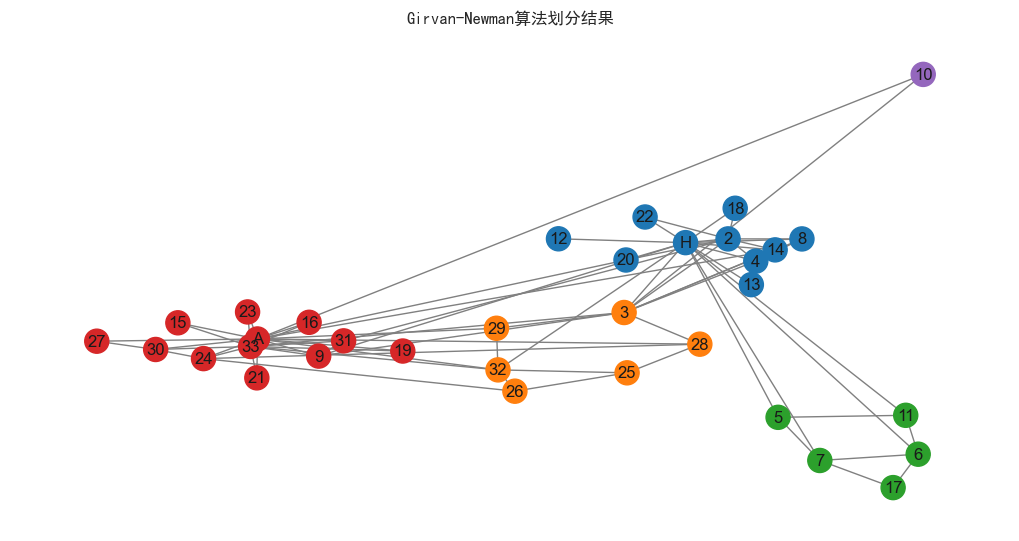

In [5]:
# 为每个节点添加属性，表示其所属的社区
for i, c in enumerate(com_GN_best):
    for n in c:
        karate.nodes[n]['GN_best'] = i

# 设置画布
plt.figure(figsize=(10, 5))
# 设置节点的位置
pos = cluster_layout(karate, com_GN_best, seed=42)
# 绘制图形
nx.draw(
    karate, pos, 
    node_color=map_color(karate, 'GN_best'), 
    labels=nx.get_node_attributes(karate, 'label'),
    edge_color='gray'
)
# 添加标题
plt.title('Girvan-Newman算法划分结果')
plt.show()

In [6]:
# 计算社区数量
len(com_GN_best)

5

In [7]:
# 计算每个社区大小
[len(c) for c in com_GN_best]

[10, 6, 5, 12, 1]

In [8]:
# 展示每个节点所属的社区。为节省空间，仅展示五个节点
for n, attr in list(karate.nodes(data=True))[:5]:
    print(f"节点 {attr['name']}\t所属的社区：{attr['GN_best']}")

节点 Mr Hi	所属的社区：0
节点 Actor 2	所属的社区：0
节点 Actor 3	所属的社区：1
节点 Actor 4	所属的社区：0
节点 Actor 5	所属的社区：2


In [9]:
# 展示每个社区的节点。为节省空间，仅展示第一个社区
for n, attr in list(karate.nodes(data=True)):
    if attr['GN_best'] == 0:
        print(f"节点 {attr['name']}\t所属的社区：{attr['GN_best']}")

节点 Mr Hi	所属的社区：0
节点 Actor 2	所属的社区：0
节点 Actor 4	所属的社区：0
节点 Actor 8	所属的社区：0
节点 Actor 12	所属的社区：0
节点 Actor 13	所属的社区：0
节点 Actor 14	所属的社区：0
节点 Actor 18	所属的社区：0
节点 Actor 20	所属的社区：0
节点 Actor 22	所属的社区：0


In [10]:
# 计算社区划分下的模块度
nx.algorithms.community.quality.modularity(karate, com_GN_best)

0.3849721706864564

In [11]:
# 展示每条边是否是跨社区的边。如果这条边连接两个不同社区，则输出“True”，否则输出“False”
# 为节省空间，仅展示两条边
for n1, n2 in list(karate.edges())[:2]:
    if karate.nodes[n1]['GN_best'] != karate.nodes[n2]['GN_best']:
        print(f"边 {karate.nodes[n1]['name']} - {karate.nodes[n2]['name']} 是跨社区的边")
    else:
        print(f"边 {karate.nodes[n1]['name']} - {karate.nodes[n2]['name']} 不是跨社区的边")

边 Mr Hi - Actor 2 不是跨社区的边
边 Mr Hi - Actor 3 是跨社区的边


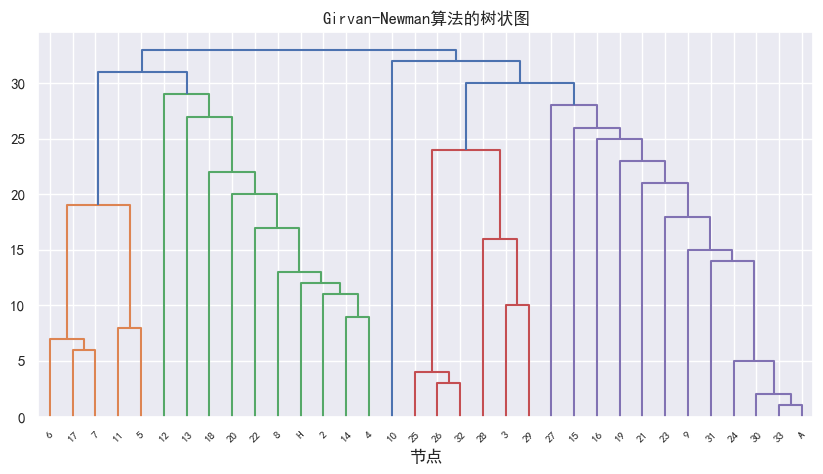

In [12]:
# 绘制树状图
plt.figure(figsize=(10, 5))
plt.title('Girvan-Newman算法的树状图')
plot_dendrogram(
    com_GN, 
    labels=nx.get_node_attributes(karate, 'label'),
    color_cut=5 # 设置颜色切割线，即将树状图划分为5个部分
)
plt.xlabel('节点')
plt.show()

In [13]:
# 查看社区数量为2时的划分结果
for com in com_GN:
    if len(com) == 2:
        com_GN_2 = com
        break
# 查看结果：
for i, com in enumerate(com_GN_2):
    print(f"社区{i+1}: {com}")

社区1: {'n11', 'n16', 'n5', 'n13', 'n19', 'n17', 'n21', 'n0', 'n6', 'n4', 'n3', 'n7', 'n1', 'n12', 'n10'}
社区2: {'n29', 'n9', 'n22', 'n15', 'n32', 'n18', 'n26', 'n33', 'n31', 'n25', 'n28', 'n23', 'n14', 'n30', 'n27', 'n20', 'n24', 'n8', 'n2'}


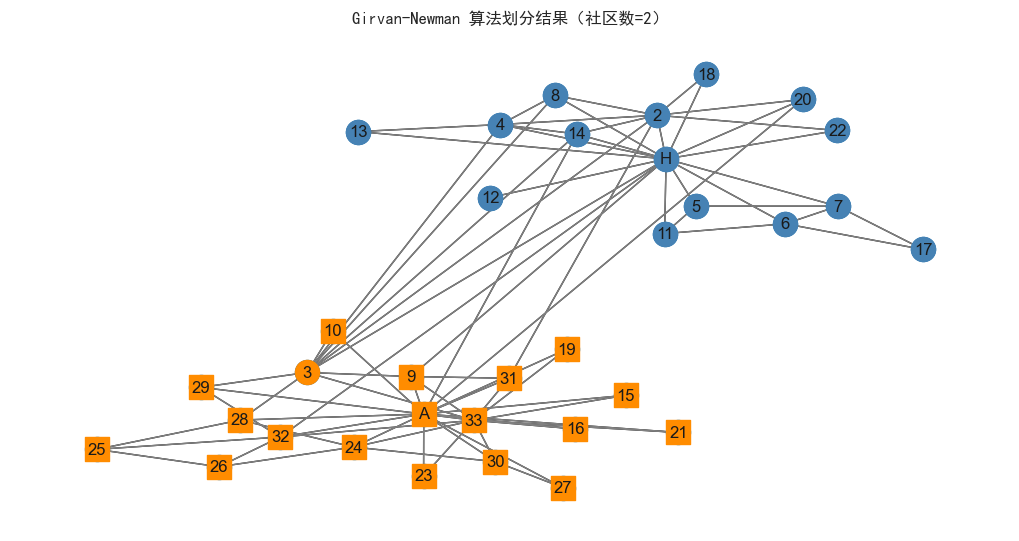

In [14]:
# 为每个节点添加属性，表示其所属的社区
for i, c in enumerate(com_GN_2):
    for n in c:
        karate.nodes[n]['GN_2'] = i

# 设置画布
plt.figure(figsize=(10, 5))
# 设置节点的位置
pos = cluster_layout(karate, com_GN_2, seed=42)

# 绘制图形
nx.draw(karate, pos, labels=nx.get_node_attributes(karate, 'label'))
for n, attr in list(karate.nodes(data=True)):
    # 设置节点的颜色-算法识别的社区
    if attr['GN_2'] == 0:
        node_color = 'steelblue'
    else:
        node_color = 'darkorange'
    # 设置节点的形状-真实的社区
    if attr['Faction'] == 1:
        node_shape = 'o'
    else:
        node_shape = 's'
    nx.draw_networkx_nodes(
        karate, pos, nodelist=[n], node_color=node_color, node_shape=node_shape
    )
nx.draw_networkx_edges(karate, pos, edge_color='gray')

# 添加标题
plt.title('Girvan-Newman 算法划分结果（社区数=2）')
plt.show()


可以看到，只有一个节点`9`被错误的划分到了另一个社区中，其余的节点都被正确的划分到了对应的社区中。

## Fast Greedy 算法

In [15]:
# fastgreedy
com_greedy = nx.algorithms.community.greedy_modularity_communities(karate)
# 查看结果：
print(f"fastgreedy算法划分的社区数：{len(com_greedy)}")
for i, com in enumerate(com_greedy):
    print(f"社区{i+1}: {com}")

fastgreedy算法划分的社区数：3
社区1: frozenset({'n29', 'n28', 'n22', 'n15', 'n26', 'n32', 'n18', 'n23', 'n14', 'n33', 'n30', 'n27', 'n31', 'n25', 'n20', 'n24', 'n8'})
社区2: frozenset({'n7', 'n9', 'n13', 'n17', 'n3', 'n21', 'n1', 'n12', 'n2'})
社区3: frozenset({'n16', 'n5', 'n19', 'n0', 'n6', 'n11', 'n4', 'n10'})


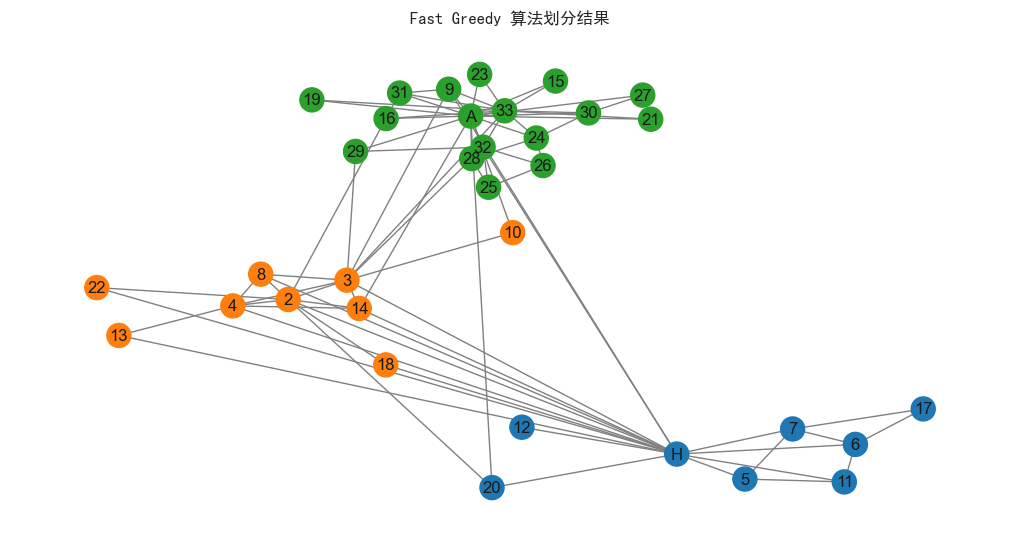

In [16]:
# 为每个节点添加属性，表示其所属的社区
for i, c in enumerate(com_greedy):
    for n in c:
        karate.nodes[n]['greedy'] = i
        
# 设置画布
plt.figure(figsize=(10, 5))
# 设置节点的位置
pos = cluster_layout(karate, com_greedy, seed=42)
# 绘制图形
nx.draw(
    karate, pos, 
    node_color=map_color(karate, 'greedy'), 
    labels=nx.get_node_attributes(karate, 'label'),
    edge_color='gray'
)
# 添加标题
plt.title('Fast Greedy 算法划分结果')
plt.show()

## Leading Eigenvector 算法

现有的`networkx`库中没有提供`Leading Eigenvector`算法的实现，可以使用`igraph`库来实现，具体实现见`R`代码，下面不做展示。

## Informap 算法

现有的`networkx`库中没有提供`Infomap`算法的实现，可以使用`igraph`库来实现，具体实现见`R`代码，下面不做展示。

## Label Proporgation 算法

In [17]:
# label proporgation
com_label_propagation = nx.algorithms.community.label_propagation.label_propagation_communities(karate)
# 查看结果：
print(f"label propagation算法划分的社区数：{len(com_label_propagation)}")
for i, com in enumerate(com_label_propagation):
    print(f"社区{i+1}: {com}")

label propagation算法划分的社区数：3
社区1: {'n11', 'n13', 'n19', 'n25', 'n17', 'n21', 'n31', 'n0', 'n4', 'n3', 'n24', 'n7', 'n1', 'n12', 'n10'}
社区2: {'n33', 'n30', 'n29', 'n9', 'n28', 'n27', 'n22', 'n15', 'n20', 'n18', 'n26', 'n32', 'n23', 'n8', 'n14', 'n2'}
社区3: {'n16', 'n6', 'n5'}


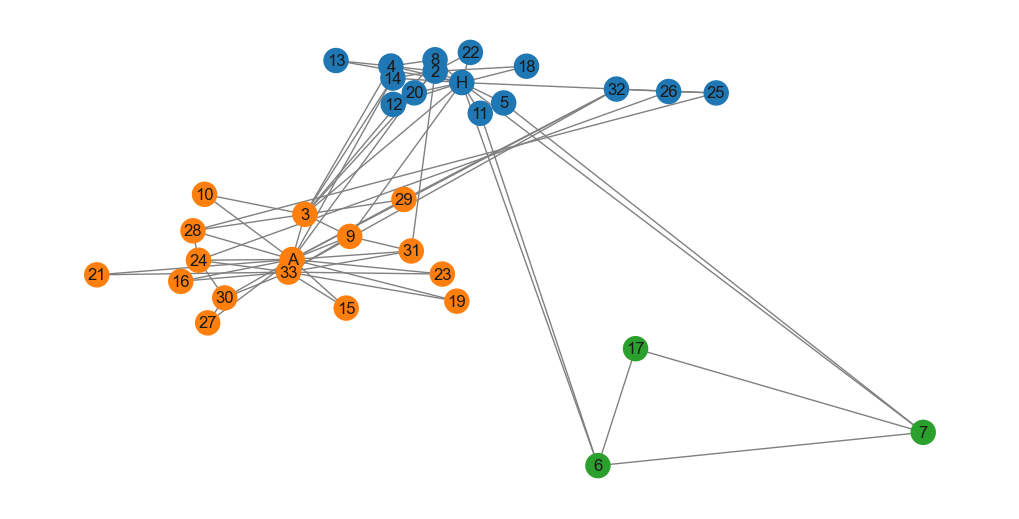

In [18]:
# 为每个节点添加属性，表示其所属的社区
for i, c in enumerate(com_label_propagation):
    for n in c:
        karate.nodes[n]['label_propagation'] = i

# 设置画布
plt.figure(figsize=(10, 5))
# 设置节点的位置
pos = cluster_layout(karate, com_label_propagation, seed=42)
# 绘制图形
nx.draw(
    karate, pos, 
    node_color=map_color(karate, 'label_propagation'), 
    labels=nx.get_node_attributes(karate, 'label'),
    edge_color='gray'
)

## Multilevel 算法

现有的`networkx`库中没有提供`Multilevel`算法的实现，可以使用`igraph`库来实现，具体实现见`R`代码，下面不做展示。

## Walktrap 算法

现有的`networkx`库中没有提供`Walktrap`算法的实现，可以使用`igraph`库来实现，具体实现见`R`代码，下面不做展示。

## Spinglass 算法

现有的`networkx`库中没有提供`Spinglass`算法的实现，可以使用`igraph`库来实现，具体实现见`R`代码，下面不做展示。

## NetworkX 库中其他的社区发现算法

### Bipartitions 算法（Kernighan-Lin 算法）

In [19]:
# Kernighan-Lin 二分法
com_KL = nx.algorithms.community.kernighan_lin_bisection(karate)
# 查看结果：
print(f"Kernighan-Lin算法划分的社区数：{len(com_KL)}")
for i, com in enumerate(com_KL):
    print(f"社区{i+1}: {com}")

Kernighan-Lin算法划分的社区数：2
社区1: {'n33', 'n30', 'n29', 'n28', 'n27', 'n31', 'n22', 'n15', 'n25', 'n20', 'n26', 'n18', 'n32', 'n23', 'n24', 'n8', 'n14'}
社区2: {'n7', 'n9', 'n16', 'n5', 'n13', 'n19', 'n17', 'n21', 'n0', 'n2', 'n6', 'n4', 'n3', 'n11', 'n1', 'n12', 'n10'}


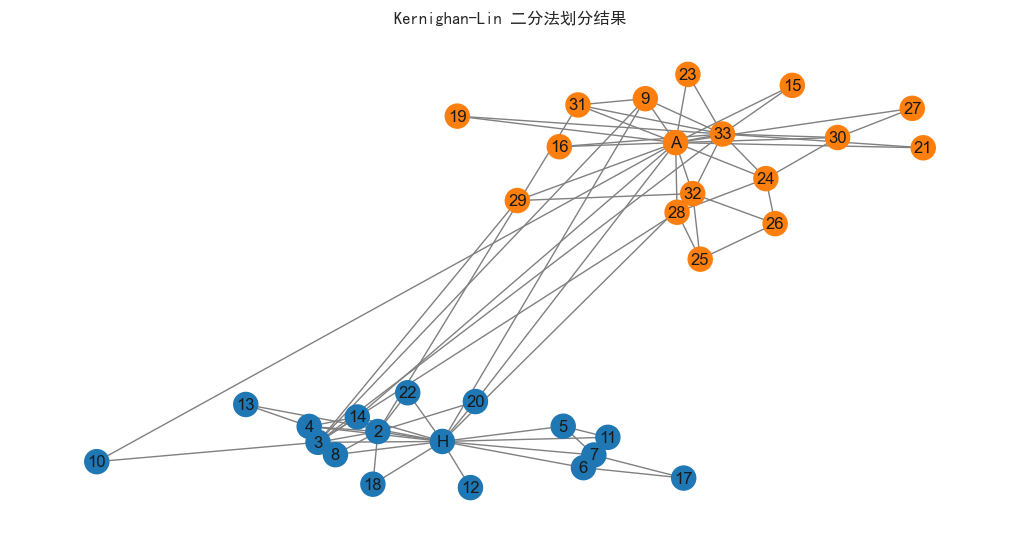

In [20]:
# 为每个节点添加属性，表示其所属的社区
for i, c in enumerate(com_KL):
    for n in c:
        karate.nodes[n]['KL'] = i

# 设置画布
plt.figure(figsize=(10, 5))
# 设置节点的位置
pos = cluster_layout(karate, com_KL, seed=42)
# 绘制图形
nx.draw(
    karate, pos, 
    node_color=map_color(karate, 'KL'), 
    labels=nx.get_node_attributes(karate, 'label'),
    edge_color='gray'
)
# 添加标题
plt.title('Kernighan-Lin 二分法划分结果')
plt.show()

### Louvain 算法

In [21]:
# Louvain
com_louvain = nx.algorithms.community.louvain_communities(karate, seed=42)
# 查看结果：
print(f"Louvain算法划分的社区数：{len(com_louvain)}")
for i, com in enumerate(com_louvain):
    print(f"社区{i+1}: {com}")

Louvain算法划分的社区数：4
社区1: {'n13', 'n3', 'n7', 'n1', 'n12', 'n2'}
社区2: {'n11', 'n16', 'n5', 'n19', 'n17', 'n0', 'n6', 'n21', 'n4', 'n10'}
社区3: {'n24', 'n31', 'n25', 'n28'}
社区4: {'n33', 'n30', 'n29', 'n9', 'n27', 'n22', 'n15', 'n32', 'n18', 'n20', 'n26', 'n23', 'n8', 'n14'}


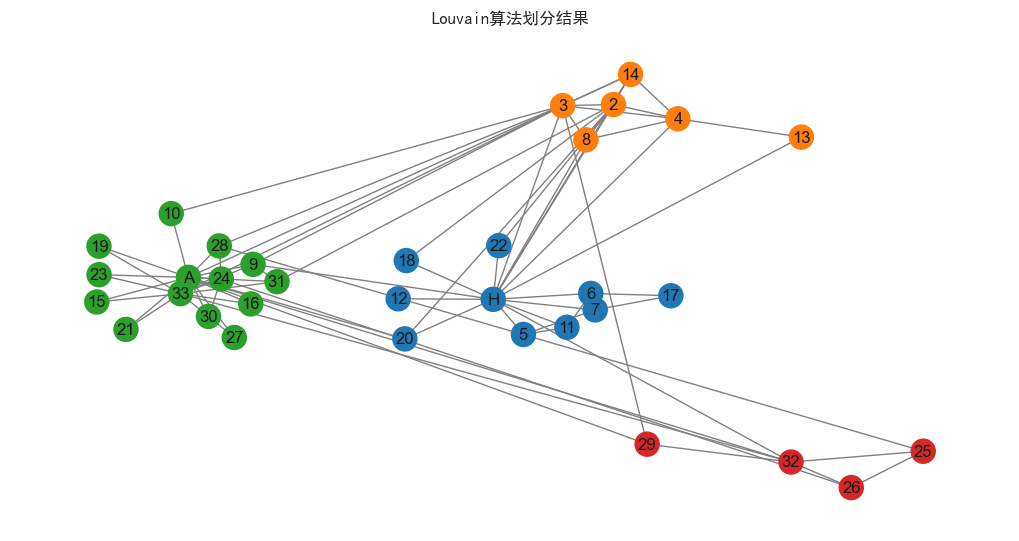

In [22]:
# 为每个节点添加属性，表示其所属的社区
for i, c in enumerate(com_louvain):
    for n in c:
        karate.nodes[n]['louvain'] = i
        
# 设置画布
plt.figure(figsize=(10, 5))
# 设置节点的位置
pos = cluster_layout(karate, com_louvain, seed=42)
# 绘制图形
nx.draw(
    karate, pos, 
    node_color=map_color(karate, 'louvain'), 
    labels=nx.get_node_attributes(karate, 'label'),
    edge_color='gray'
)
# 添加标题
plt.title('Louvain算法划分结果')
plt.show()

## 社区结果评价

In [23]:
# 获取真实社区划分
true_com = nx.get_node_attributes(karate, 'Faction')
true_com = list(true_com.values())
print(f"真实社区划分: {true_com}")

真实社区划分: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]


In [24]:
# GN算法进行社区发现
# 前文已经执行过，这里直接调用划分成两个社区的结果
pred_com = nx.get_node_attributes(karate, 'GN_2')
pred_com = list(pred_com.values())
print(f"Girvan-Newman算法划分结果: {pred_com}")

Girvan-Newman算法划分结果: [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [25]:
# 计算兰德指数
metrics.rand_score(true_com, pred_com)

0.9411764705882353

In [26]:
# 计算调整的兰德指数
metrics.adjusted_rand_score(true_com, pred_com)

0.882302454654689

In [27]:
# 计算标准化互信息
metrics.normalized_mutual_info_score(true_com, pred_com)

0.8364981174679549

In [28]:
# 计算社区划分的模块度
nx.algorithms.community.quality.modularity(karate, [set(com) for com in com_GN_2])

0.3476602762317048

`networkx`库中的社区结果评价指标有限，这里用了`sklearn`库中`metrics`模块中提供的一些指标作为补充，更多书中的指标以`R`代码实现，下面不做展示。

## 案例：统计学科合作者网络

In [29]:
# 读入边数据
data = pd.read_csv('../../Data/edge_largest.csv')
g = nx.from_pandas_edgelist(data, 'source', 'target')
graph_info(g)

Graph with 4925 nodes and 10191 edges.
Graph type:      undirected unweighted 
Node attributes: 
Edge attributes: 
Edge list:
[ 0] A10014-0       -- A11813-0      	[ 1] A10014-0       -- A18443-0      
[ 2] A10014-0       -- A25933        	[ 3] A10014-0       -- A26500-1      
[ 4] A10014-0       -- A27463-58     	[ 5] A10014-0       -- A27664-0      
[ 6] A10014-0       -- A29195-1      	[ 7] A10014-0       -- A37213-0      
[ 8] A10014-0       -- A40785-0      	[ 9] A10014-0       -- A41093-0      
[10] A10014-0       -- A41419-0      	[11] A10014-0       -- A49668-2      
...


In [30]:
# 获取核心子图
g_core = nx.k_core(g, k=4)
graph_info(g_core)

Graph with 1061 nodes and 3310 edges.
Graph type:      undirected unweighted 
Node attributes: 
Edge attributes: 
Edge list:
[ 0] A23520-2       -- A24806-0      	[ 1] A23520-2       -- A27219-10     
[ 2] A23520-2       -- A3515-0       	[ 3] A23520-2       -- A35694-0      
[ 4] A23520-2       -- A40370-0      	[ 5] A23520-2       -- A4122-0       
[ 6] A23520-2       -- A47461-1      	[ 7] A23520-2       -- A6715-0       
[ 8] A3967          -- A15337-0      	[ 9] A3967          -- A2440         
[10] A3967          -- A35830-1      	[11] A3967          -- A41403        
...


In [31]:
# 使用Louvain算法进行社区发现
com = nx.algorithms.community.louvain_communities(g_core, seed=42)
# 展示每个社区的大小
print([len(c) for c in com])

[18, 6, 38, 78, 27, 11, 55, 6, 6, 27, 31, 7, 5, 6, 48, 5, 6, 5, 12, 29, 33, 43, 5, 36, 7, 5, 7, 5, 5, 36, 17, 10, 6, 24, 21, 40, 10, 26, 32, 11, 90, 20, 55, 11, 13, 39, 18, 5, 5]


In [32]:
# 为每个节点添加属性，表示其所属的社区
for i, c in enumerate(com):
    for n in c:
        g_core.nodes[n]['community'] = i

# 查看A13633-1节点所属的社区
com_sub_index = g_core.nodes['A13633-1']['community']
# 提取对应社区的所有作者构成的子网络
g_sub = g_core.subgraph(com[com_sub_index])
graph_info(g_sub)

Graph with 78 nodes and 202 edges.
Graph type:      undirected unweighted 
Node attributes: community 
Edge attributes: 
Edge list:
[ 0] A15184-0   -- A45400-1  	[ 1] A15184-0   -- A26710-0  
[ 2] A15184-0   -- A38738    	[ 3] A15184-0   -- A27460-25 
[ 4] A15184-0   -- A45174-3  	[ 5] A15184-0   -- A42347-0  
[ 6] A8226-0    -- A28274-1  	[ 7] A8226-0    -- A32246-0  
[ 8] A8226-0    -- A32347-0  	[ 9] A8226-0    -- A49674-0-3
[10] A10226-3   -- A27025-0-0	[11] A10226-3   -- A27450-43 
...


In [33]:
# 计算社区作者构成的合作网络的密度
nx.density(g_sub)

0.06726606726606726

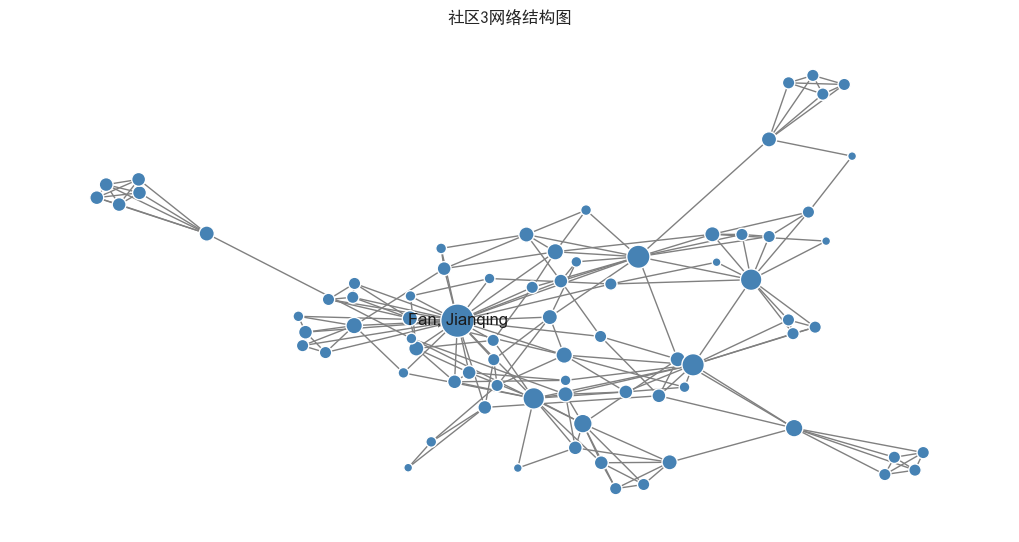

In [34]:
# 设置节点大小与度成正比
node_size = [d * 20 for d in dict(g_sub.degree()).values()]
# 设置ID为'A13633-1'的作者的标签为'Fan, Jianqing' 
labels = {}
for n in g_sub.nodes():
    if n == 'A13633-1':
        labels[n] = 'Fan, Jianqing'
    else:
        labels[n] = ''

# 设置画布
plt.figure(figsize=(10, 5))
# 设置节点的位置
pos = nx.spring_layout(g_sub, seed=42)
# 绘制图形
nx.draw(
    g_sub, pos, 
    node_color='steelblue', 
    node_size=node_size,
    labels=labels,
    edge_color='gray',
    edgecolors='white'
)
# 添加标题
plt.title(f'社区{com_sub_index}网络结构图')
plt.show()